In [1]:
import pandas as pd
import json
import os
from collections import Counter
import matplotlib.pyplot as plt
import re
from datetime import datetime
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Function

In [2]:
def format_number(num):
    return f"{num:,.0f}".replace(",", ".")

## Aired `random date` to `month-year`

In [3]:
def extract_first_release(aired_str):
    """
    Extract first month and year from aired string
    
    Parameters:
    aired_str (str): The aired date string to process
    
    Returns:
    str: Release date in MM-YYYY format or None if cannot be processed
    """
    if pd.isna(aired_str) or aired_str == '':
        return None
    
    # Dictionary untuk konversi nama bulan ke angka
    month_dict = {
        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
        'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
        'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }
    
    # Bersihkan string dari dash di awal
    aired_str = aired_str.strip('-')
    
    try:
        # Case 1: Format dengan bulan dan tahun (e.g., "Dec-1,-1933" atau "Aug-29,-1965-to-Jun-28,-1967")
        month_year_pattern = r'([A-Za-z]+)-\d+,?-?(\d{4})'
        match = re.search(month_year_pattern, aired_str)
        if match:
            month_str, year = match.groups()
            month_num = month_dict.get(month_str[:3])
            if month_num:
                return f"{month_num}-{year}"
        
        # Case 2: Format tahun saja (e.g., "2017")
        year_pattern = r'(\d{4})'
        match = re.search(year_pattern, aired_str)
        if match:
            year = match.group(1)
            return f"01-{year}"  # Default ke Januari untuk tahun saja
        
        # Case 3: Format bulan dan tahun tanpa tanggal (e.g., "Apr-2001")
        month_year_simple = r'([A-Za-z]+)-(\d{4})'
        match = re.search(month_year_simple, aired_str)
        if match:
            month_str, year = match.groups()
            month_num = month_dict.get(month_str[:3])
            if month_num:
                return f"{month_num}-{year}"
                
        return None
        
    except (ValueError, AttributeError):
        return None

## Analysis By Genre

In [4]:
def genre_analysis(genre_analysis, dataframe, limit=0):
    df = dataframe
    df_analysis = df[df['genre'].apply(lambda x: genre_analysis in x)].copy()  # Use .copy() to avoid chained assignment
    df_analysis.loc[:, 'aired'] = pd.to_datetime(df_analysis['aired'], format='%m-%Y')  # Use .loc
    df_analysis.loc[:, 'year'] = df_analysis['aired'].dt.year  # Use .loc
    df_analysis.loc[:, 'month'] = df_analysis['aired'].dt.month  # Use .loc

    # Get the current year
    current_year = datetime.now().year

    # Filter data based on the limit (number of years back)
    if limit > 0:
        df_analysis = df_analysis[df_analysis['year'] >= (current_year - limit)]

    monthly_stats = df_analysis.groupby(['year', 'month']).size().reset_index(name='count')
    monthly_stats['date'] = pd.to_datetime(monthly_stats[['year', 'month']].assign(day=1))

    plt.figure(figsize=(20, 10))
    plt.plot(monthly_stats['date'], monthly_stats['count'], marker='o', linestyle='-', color='blue')
    plt.title(f'Monthly Statistics of {genre_analysis} Aired Data', fontsize=24)
    plt.xlabel('Date', fontsize=24)
    plt.ylabel('Count', fontsize=24)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # print(monthly_stats.to_markdown())
    return monthly_stats

## Genre per Year

In [5]:
def genre_analysis_decade(genre_analysis, dataframe, limit=0):
    df = dataframe
    
    df_analysis = df[df['genre'].apply(lambda x: genre_analysis in x)].copy()  # Use .copy() to avoid chained assignment
    
    df_analysis.loc[:, 'aired'] = pd.to_datetime(df_analysis['aired'], format='%m-%Y')  # Use .loc
    df_analysis.loc[:, 'year'] = df_analysis['aired'].dt.year  # Use .loc
    df_analysis.loc[:, 'month'] = df_analysis['aired'].dt.month  # Use .loc
    
    current_year = datetime.now().year
        
    df_analysis['decade'] = (df_analysis['year'] // limit) * limit
    decade_stats = df_analysis.groupby('decade').size().reset_index(name='count')
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.bar(decade_stats['decade'], decade_stats['count'], color='blue')
    plt.title(f'Decade Statistics of {genre_analysis} Aired Data (Last {current_year} Years)', fontsize=24)
    plt.xlabel('Decade', fontsize=24)
    plt.ylabel('Count', fontsize=24)
    plt.grid(True)
    plt.xticks(decade_stats['decade'], rotation=45)
    plt.tight_layout()
    plt.show()
    
    # print(decade_stats.to_markdown())
    
    return decade_stats

## Heatmap Trend

In [6]:
import seaborn as sns

def plot_genre_heatmap(dataframe, top_n_genres=15, start_year=2000, genres=[]):
    # Process data
    df = dataframe.copy()
    df['aired'] = pd.to_datetime(df['aired'], format='%m-%Y')
    df['year'] = df['aired'].dt.year
    
    # Filter by start year
    df = df[df['year'] >= start_year]
    
    # Count genres by year
    genre_counts = {}
    years = sorted(df['year'].unique())
    
    for year in years:
        year_data = df[df['year'] == year]
        year_genres = {}
        
        for _, row in year_data.iterrows():
            for genre in row['genre']:
                year_genres[genre] = year_genres.get(genre, 0) + 1
        
        genre_counts[year] = year_genres
    
    # Find top N genres across all years
    all_genre_counts = {}
    for year_data in genre_counts.values():
        for genre, count in year_data.items():
            all_genre_counts[genre] = all_genre_counts.get(genre, 0) + count
    
    top_genres = sorted(all_genre_counts.items(), key=lambda x: x[1], reverse=True)[:top_n_genres]
    
    if len(genres) > 0:
        top_genres = [(g, all_genre_counts[g]) for g in genres if g in all_genre_counts]
        
    top_genre_names = [g[0] for g in top_genres]
    
    # Create DataFrame for heatmap
    heatmap_data = []
    for year in years:
        row = {'year': year}
        year_data = genre_counts[year]
        
        for genre in top_genre_names:
            row[genre] = year_data.get(genre, 0)
        
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data)
    heatmap_df.set_index('year', inplace=True)
    
    # Create heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Popular Anime Genres by Year', fontsize=16)
    plt.ylabel('Year', fontsize=12)
    plt.xlabel('Genre', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return heatmap_df

## Trend Calculation

In [7]:
# Function to analyze and predict genre trends
def analyze_genre_trends(df, prediction_year=2025, focus_years=5):
    """
    Analyze genre trends and predict popularity for a specific year
    
    Parameters:
    df: DataFrame containing genre counts by year
    prediction_year: Year to predict (default: 2025)
    focus_years: Number of recent years to use for trend analysis (default: 5)
    
    Returns:
    DataFrame with predicted values and growth metrics
    """
    # Create a copy to avoid modifying the original
    trend_df = df.copy()
    
    # Filter for complete years (exclude prediction_year which may be incomplete)
    complete_years = [year for year in trend_df.index if year < prediction_year]
    
    # Get the most recent complete years for trend analysis
    recent_years = complete_years[-focus_years:]
    
    # Prepare results dataframe
    results = pd.DataFrame(index=trend_df.columns)
    
    # Calculate average counts over recent years
    results['recent_avg'] = trend_df.loc[recent_years].mean()
    
    # Calculate growth rate using linear regression
    X = np.array(recent_years).reshape(-1, 1)
    
    growth_rates = []
    predictions = []
    r2_scores = []
    
    for genre in trend_df.columns:
        y = trend_df.loc[recent_years, genre].values
        
        # Fit linear regression model
        model = LinearRegression()
        model.fit(X, y)
        
        # Calculate growth rate (slope)
        growth_rate = model.coef_[0]
        growth_rates.append(growth_rate)
        
        # Make prediction for the target year
        prediction = model.predict([[prediction_year]])[0]
        predictions.append(max(0, prediction))  # Ensure non-negative prediction
        
        # Calculate R-squared to assess trend reliability
        r2 = model.score(X, y)
        r2_scores.append(r2)
    
    results['growth_rate'] = growth_rates
    results['prediction'] = predictions
    results['trend_reliability'] = r2_scores
    
    # Calculate normalized score to rank genres (combining current popularity and growth)
    results['normalized_score'] = (
        (results['recent_avg'] / results['recent_avg'].max()) * 0.6 +
        (results['growth_rate'] / results['growth_rate'].max() if results['growth_rate'].max() > 0 else 0) * 0.4
    )
    
    # Sort by normalized score (descending)
    results = results.sort_values('normalized_score', ascending=False)
    
    return results

In [8]:
# Function to visualize the results
def visualize_genre_trends(df, analysis_df, top_n=10):
    """
    Visualize genre trends and predictions
    
    Parameters:
    df: Original data DataFrame
    analysis_df: Analysis results DataFrame
    top_n: Number of top genres to display (default: 10)
    """
    top_genres = analysis_df.index[:top_n].tolist()
    
    # Plot historical data and predictions for top genres
    plt.figure(figsize=(14, 8))
    
    for genre in top_genres:
        plt.plot(df.index[-6:-1], df.loc[df.index[-6:-1], genre], marker='o', label=genre)
        
        # Add prediction point
        prediction = analysis_df.loc[genre, 'prediction']
        plt.plot(df.index[-1], prediction, marker='*', markersize=10, 
                 color=plt.gca().lines[-1].get_color())
    
    plt.title('Top Anime Genre Trends and Predictions (2020-2025)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Anime Titles', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Plot normalized scores for top genres
    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_genres[::-1], analysis_df.loc[top_genres[::-1], 'normalized_score'], color='lime')
    
    # Add growth rate indicators
    for i, genre in enumerate(top_genres[::-1]):
        growth = analysis_df.loc[genre, 'growth_rate']
        color = 'green' if growth > 0 else 'red'
        plt.text(0.01, i, f"{'↑' if growth > 0 else '↓'}", color=color, 
                 fontsize=14, verticalalignment='center')
    
    plt.title('Predicted Popular Anime Genres for 2025', fontsize=16)
    plt.xlabel('Normalized Popularity Score', fontsize=12)
    plt.tight_layout()
    
    # Create a prediction summary table
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')
    
    table_data = []
    headers = ['Genre', 'Recent Average', 'Growth Rate', '2025 Prediction', 'Trend Reliability']
    
    for genre in top_genres:
        table_data.append([
            genre,
            f"{analysis_df.loc[genre, 'recent_avg']:.1f}",
            f"{analysis_df.loc[genre, 'growth_rate']:.1f}",
            f"{analysis_df.loc[genre, 'prediction']:.1f}",
            f"{analysis_df.loc[genre, 'trend_reliability']:.2f}"
        ])
    
    table = ax.table(cellText=table_data, colLabels=headers, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    plt.title('Anime Genre Prediction Details for 2025', fontsize=16)
    plt.tight_layout()


In [9]:
# Function to provide textual analysis of the trends
def generate_trend_analysis(analysis_df, top_n=100):
    """
    Generate a textual analysis of anime genre trends
    
    Parameters:
    analysis_df: Analysis results DataFrame
    top_n: Number of top genres to analyze (default: 10)
    
    Returns:
    String containing the analysis
    """
    top_genres = analysis_df.index[:top_n].tolist()
    
    analysis = "# Anime Genre Trend Analysis for 2025\n\n"
    
    # Overall trend summary
    analysis += "## Overall Trend Summary\n"
    analysis += "Based on data from the past 5 years, the following genres are projected to be most popular in 2025:\n\n"
    
    for i, genre in enumerate(top_genres, 1):
        recent_avg = analysis_df.loc[genre, 'recent_avg']
        growth = analysis_df.loc[genre, 'growth_rate']
        prediction = analysis_df.loc[genre, 'prediction']
        
        trend_direction = "increasing" if growth > 0 else "decreasing"
        growth_percent = abs(growth) / recent_avg * 100 if recent_avg > 0 else 0
        
        analysis += f"{i}. **{genre}**: Currently averaging {recent_avg:.1f} titles per year, "
        analysis += f"with a {trend_direction} trend ({growth_percent:.1f}% per year). "
        analysis += f"Projected to have {prediction:.1f} titles in 2025.\n"
    
    # Rising stars
    rising_genres = analysis_df[analysis_df['growth_rate'] > 10].index.tolist()[:5]
    if rising_genres:
        analysis += "\n## Rising Star Genres\n"
        analysis += "These genres show significant positive growth and may become more prominent:\n\n"
        for genre in rising_genres:
            growth = analysis_df.loc[genre, 'growth_rate']
            analysis += f"- **{genre}**: Growing at {growth:.1f} titles per year\n"
    
    # Conclusion
    analysis += "\n## Conclusion\n"
    analysis += "The anime industry in 2025 is likely to be dominated by "
    analysis += ", ".join([f"**{genre}**" for genre in top_genres[:3]])
    analysis += f", with **{top_genres[0]}** leading the way. "
    analysis += "Cross-genre titles that combine elements from multiple popular categories "
    analysis += "are likely to be particularly successful.\n\n"
    analysis += "The 2025 data is currently incomplete as we're still in early 2025, "
    analysis += "but the trends from previous years provide a reliable indication of what to expect."
    
    return analysis


# Get Data

In [10]:
file_path = './dataset/data.json'

if os.stat(file_path).st_size == 0:  # Check if the file is empty
    print("Error: JSON file is empty.")
    data = {}  # Set default empty dictionary
else:
    try:
        with open(file_path, "r") as file:
            data = json.load(file)
    except json.JSONDecodeError:
        print("Error: JSON file is corrupt or not formatted correctly.")
        data = {}  # Set default empty dictionary

# Dataset

In [11]:
num_ = 'all'
# num_ = 10000

df = pd.DataFrame(data)

if num_ != 'all':
    df = df[:num_]
    
df['rank'] = pd.to_numeric(df['rank'], errors='coerce')
df['rank'] = df['rank'].fillna(pd.Series(df.index + 1))

df['mal_id'] = pd.to_numeric(df['mal_id'], errors='coerce').fillna(0)
df['aired'] = df['aired'].apply(extract_first_release)

df = df.sort_values(by='rank')

df['member'] = pd.to_numeric(df['member'].str.replace(',', '').replace('', '0'), errors='coerce').fillna(0).astype(int)
df['favorite'] = pd.to_numeric(df['favorite'].str.replace(',', '').replace('', '0'), errors='coerce').fillna(0).astype(int)

df.to_json('./dataset/dataset.json', orient='records')
df.head(2)

,id,mal_id,title,synopsis,rank,link,episode,type,genre,producer,studio,theme,demographic,duration,rating,aired,premiered,member,favorite,image_url
0,fde8d17c-ee8e-4e76-8e19-01fa8545ed79,52991,Sousou no Frieren,During their decade-long quest to defeat the D...,1.0,https://myanimelist.net/anime/52991/Sousou_no_...,28,TV,"[Adventure, Drama, Fantasy, Shounen]","[Aniplex, Dentsu, Shogakukan-Shueisha Producti...",[Madhouse],[],[Shounen],24 min. per ep.,PG-13-Teens13orolder,09-2023,Fall-2023,1029859,62737,https://cdn.myanimelist.net/images/anime/1015/...
1,58e243b6-9769-4625-97d4-79f943db1b5b,5114,Fullmetal Alchemist: Brotherhood,After a horrific alchemy experiment goes wrong...,2.0,https://myanimelist.net/anime/5114/Fullmetal_A...,64,TV,"[Action, Adventure, Drama, Fantasy, Military, ...","[Aniplex, Square Enix, Mainichi Broadcasting S...",[Bones],[Military],[Shounen],24 min. per ep.,R-17+(violence&profanity),04-2009,Spring-2009,3480208,231770,https://cdn.myanimelist.net/images/anime/1208/...


In [ ]:
df.loc[:, 'year'] = pd.to_datetime(df['aired'], format='%m-%Y', errors='coerce').dt.year.astype('Int64')

df['genre'] = df['genre'].apply(lambda x: eval(x) if isinstance(x, str) else x)

df_exploded = df.explode('genre')

genre_year_counts = df_exploded.groupby(['genre', 'year']).size().unstack(fill_value=0)

genre_year_counts = genre_year_counts.reindex(sorted(genre_year_counts.columns), axis=1)

genre_year_counts

year,1917,1918,1922,1923,1924,1925,1926,1927,1928,1929,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
genre,,,,,,,,,,,,,,,,,,,,,
Action,0,0,0,0,0,0,0,0,1,2,...,200,233,223,207,235,248,286,286,110,9
Adult Cast,0,0,0,0,0,0,0,0,0,0,...,23,31,26,28,28,26,42,42,25,1
Adventure,0,0,0,0,0,0,2,1,0,1,...,162,151,155,140,133,161,190,202,68,2
Anthropomorphic,0,0,0,0,0,0,0,0,0,0,...,68,71,86,66,50,38,46,53,16,0
Avant Garde,0,0,0,0,0,0,0,0,0,0,...,41,34,58,28,39,38,36,39,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vampire,0,0,0,0,0,0,0,0,0,0,...,8,10,4,5,7,7,7,10,3,0
Video Game,0,0,0,0,0,0,0,0,0,0,...,11,19,12,12,5,9,16,11,0,0
Villainess,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,3,2,6,3,3,0


In [61]:
df['studio'] = df['studio'].apply(lambda x: eval(x) if isinstance(x, str) else x)

df_exploded = df.explode('studio')

studio_year_counts = df_exploded.groupby(['studio', 'year']).size().unstack(fill_value=0)

studio_year_counts = studio_year_counts.reindex(sorted(studio_year_counts.columns), axis=1)

studio_year_counts

year,1917,1918,1922,1923,1924,1925,1926,1927,1928,1929,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
studio,,,,,,,,,,,,,,,,,,,,,
100studio,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
10Gauge,0,0,0,0,0,0,0,0,0,0,...,1,0,0,3,0,0,0,0,0,0
1IN,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2:10 Animation,0,0,0,0,0,0,0,0,0,0,...,2,1,0,2,2,1,0,0,0,0
33 Collective,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
teevee graphics,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
trenova,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ufotable,0,0,0,0,0,0,0,0,0,0,...,3,3,3,2,0,1,1,1,0,0


In [63]:
df['demographic'] = df['demographic'].apply(lambda x: eval(x) if isinstance(x, str) else x)

df_exploded = df.explode('demographic')

demographic_year_counts = df_exploded.groupby(['demographic', 'year']).size().unstack(fill_value=0)

demographic_year_counts = demographic_year_counts.reindex(sorted(demographic_year_counts.columns), axis=1)

demographic_year_counts.to_csv('./dataset/demographic_year_counts.csv')

# Analysis Count per Genres

In [13]:
df['genre'] = df['genre'].apply(lambda x: eval(x) if isinstance(x, str) else x)

genre_stats = {}

for _, row in df.iterrows():
    genres = row['genre']
    members = row['member']
    favorites = row['favorite']
    
    
    if isinstance(genres, list):
        for genre in genres:
            if genre in genre_stats:
                genre_stats[genre]['count'] += 1
                genre_stats[genre]['total_member'] += members
                genre_stats[genre]['total_favorite'] += favorites
                
                genre_stats[genre]['min_member'] = min(genre_stats[genre]['min_member'], members)
                genre_stats[genre]['max_member'] = max(genre_stats[genre]['max_member'], members)
                genre_stats[genre]['min_favorite'] = min(genre_stats[genre]['min_favorite'], favorites)
                genre_stats[genre]['max_favorite'] = max(genre_stats[genre]['max_favorite'], favorites)
            else:
                genre_stats[genre] = {
                    'count': 1, 
                    'total_member': members,
                    'total_favorite': favorites,
                    'min_member': members,
                    'max_member': members,
                    'min_favorite': favorites,
                    'max_favorite': favorites,
                }

# Konversi dictionary ke DataFrame
df_genre_stats = pd.DataFrame([
    {  
        'genre': genre, 
        'count': data['count'], 
        'min_member': data['min_member'],
        'max_member': data['max_member'],
        'avg_member': round(data['total_member'] / data['count']),
        'min_favorite': data['min_favorite'],
        'max_favorite': data['max_favorite'],
        'avg_favorite_member': round(data['total_favorite'] / data['count']),
        
    }
    for genre, data in genre_stats.items()
])

df_genre_stats = df_genre_stats.sort_values(by='count', ascending=False).reset_index(drop=True)

df_genre_stats.style.set_properties(**{
    'background-color': 'darkgreen', 
    'color': 'white', 
    'font-weight': 'bold', 
    'border-bottom': '1px solid white'
})

,genre,count,min_member,max_member,avg_member,min_favorite,max_favorite,avg_favorite_member
0,Comedy,7454,0,3347226,43217,0,65514,348
1,Kids,6792,0,652760,1475,0,5550,5
2,Fantasy,5706,0,3480208,55413,0,234086,617
3,Action,5245,0,4112272,91469,0,234086,1141
4,Music,4818,0,2295141,5520,0,87361,71
5,Adventure,4169,0,3480208,53806,0,234086,741
6,Sci-Fi,3299,0,2665792,45840,0,194340,574
7,Drama,2925,0,4112272,83977,0,231770,1406
8,School,2081,0,3139006,132306,0,111589,1254
9,Romance,2050,35,3172259,118571,0,87361,1102


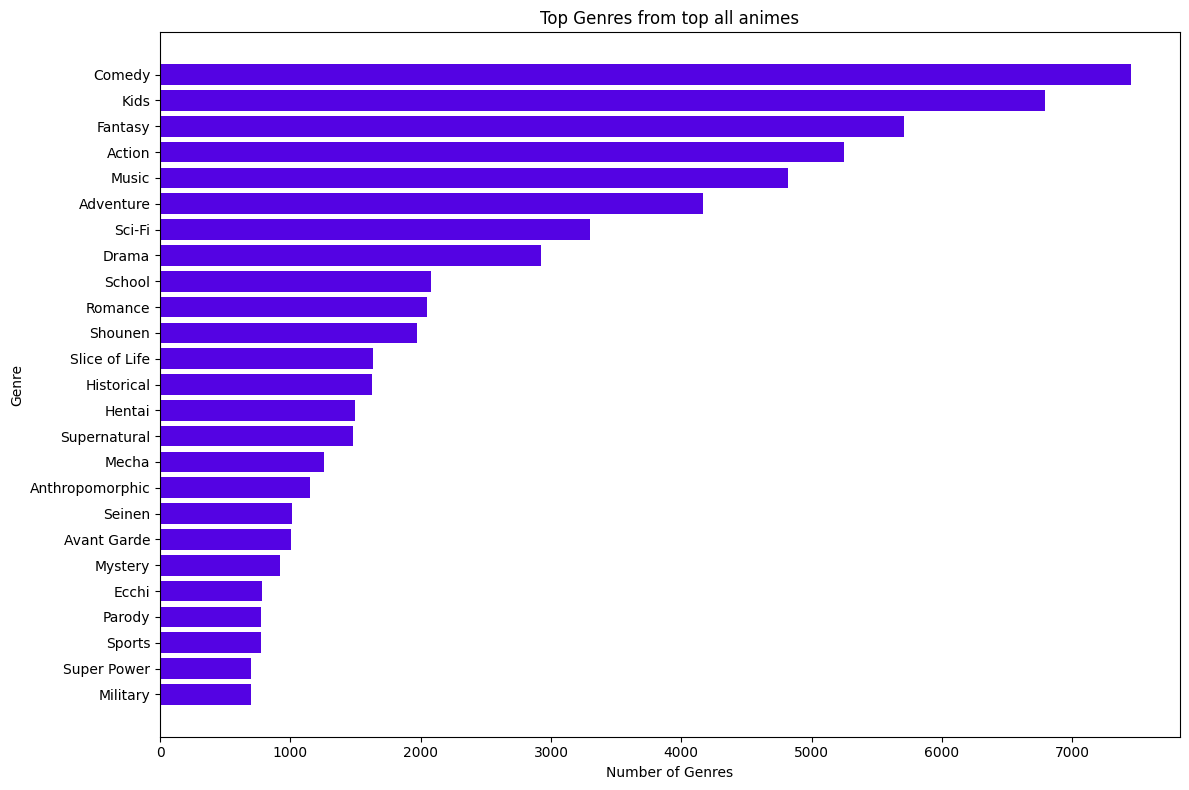

In [14]:
plt.figure(figsize=(12, 8))
plt.barh(df_genre_stats['genre'][:25], df_genre_stats['count'][:25], color=np.random.rand(128, 3)[0])
plt.xlabel('Number of Genres')
plt.ylabel('Genre')
plt.title(f'Top Genres from top {num_} animes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'image/top_{num_}_genres.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
df_count = []
for i in df_genre_stats['genre'].unique():
    df_filtered = df[df['genre'].apply(lambda x: i in x)]
    df_filtered.reset_index()
    
    total = len(df_filtered)
    
    # Inisialisasi nilai default untuk 1st, 2nd, dan 3rd place
    first_place = df_filtered.iloc[0]['title'] if total >= 1 else '-'
    second_place = df_filtered.iloc[1]['title'] if total >= 2 else '-'
    third_place = df_filtered.iloc[2]['title'] if total >= 3 else '-'
    # forth_place = df_filtered.iloc[3]['title'] if total >= 3 else '-'
    # fifth_place = df_filtered.iloc[4]['title'] if total >= 3 else '-'
    
    # Tambahkan data ke df_count
    df_count.append({
        "genre": i,
        "total": total,
        "1st Place": first_place,
        "2nd Place": second_place,
        "3rd Place": third_place,
        # "4th Place": forth_place,
        # "5th Place": fifth_place,
    })

df_count = pd.DataFrame(df_count)
df_count.style.set_properties(**{
    'background-color': 'darkgreen', 
    'color': 'white', 
    'font-weight': 'bold', 
    'border-bottom': '1px solid white'
})

,genre,total,1st Place,2nd Place,3rd Place
0,Comedy,7454,Gintama°,Gintama: The Final,Gintama'
1,Kids,6792,Tanoshii Muumin Ikka,Stand By Me Doraemon 2,Stand By Me Doraemon
2,Fantasy,5706,Sousou no Frieren,Fullmetal Alchemist: Brotherhood,One Piece Fan Letter
3,Action,5245,Fullmetal Alchemist: Brotherhood,One Piece Fan Letter,Shingeki no Kyojin Season 3 Part 2
4,Music,4818,Bocchi the Rock!,Hibike! Euphonium 3,Shigatsu wa Kimi no Uso
5,Adventure,4169,Sousou no Frieren,Fullmetal Alchemist: Brotherhood,One Piece Fan Letter
6,Sci-Fi,3299,Steins;Gate,Gintama°,Gintama: The Final
7,Drama,2925,Sousou no Frieren,Fullmetal Alchemist: Brotherhood,Steins;Gate
8,School,2081,Kaguya-sama wa Kokurasetai: Ultra Romantic,Haikyuu!! Karasuno Koukou vs. Shiratorizawa Gakuen Koukou,Jujutsu Kaisen 2nd Season
9,Romance,2050,Kaguya-sama wa Kokurasetai: Ultra Romantic,Fruits Basket: The Final,Clannad: After Story


In [16]:
print(df_genre_stats['genre'].unique())
len(df_genre_stats['genre'].unique())

['Comedy' 'Kids' 'Fantasy' 'Action' 'Music' 'Adventure' 'Sci-Fi' 'Drama'
 'School' 'Romance' 'Shounen' 'Slice of Life' 'Historical' 'Hentai'
 'Supernatural' 'Mecha' 'Anthropomorphic' 'Seinen' 'Avant Garde' 'Mystery'
 'Ecchi' 'Parody' 'Sports' 'Super Power' 'Military' 'Martial Arts'
 'Adult Cast' 'Space' 'Mythology' 'Horror' 'Shoujo' 'Harem'
 'Psychological' 'Suspense' 'Isekai' 'Idols (Female)' 'Mahou Shoujo'
 'Strategy Game' 'Team Sports' 'Educational' 'Detective' 'Racing' 'Gore'
 'Gag Humor' 'Award Winning' 'Samurai' 'CGDCT' 'Workplace' 'Urban Fantasy'
 'Gourmet' 'Boys Love' 'Idols (Male)' 'Iyashikei' 'Vampire' 'Video Game'
 'Josei' 'Time Travel' 'Reincarnation' 'Pets' 'Performing Arts'
 'Girls Love' 'Love Polygon' 'Otaku Culture' 'Organized Crime'
 'Combat Sports' 'Visual Arts' 'Reverse Harem' 'Erotica' 'Childcare'
 'Survival' 'Delinquents' 'Crossdressing' 'High Stakes Game' 'Medical'
 'Showbiz' 'Love Status Quo' 'Magical Sex Shift' 'Villainess']


78

# Analysis time improvement per Genre

In [17]:
Genre = 'Romance'
df_filtered = df[df['genre'].apply(lambda x: Genre in x)]
print(f'Total {Genre} Animes: {len(df_filtered)}')

Total Romance Animes: 2050


In [18]:
genre_pure = df[df['genre'].apply(lambda x: x == [Genre])]

genre_mixed = df[df['genre'].apply(lambda x: Genre in x and len(x) > 1)]

In [19]:
genre_pure.head(3)

,id,mal_id,title,synopsis,rank,link,episode,type,genre,producer,studio,theme,demographic,duration,rating,aired,premiered,member,favorite,image_url
25792,7be08860-9d7e-4e4c-976b-6b0ac638b54b,22961,Date A Live II: Kurumi Star Festival,"On the day of the Tanabata festival, Shidou It...",828.0,https://myanimelist.net/anime/22961/Date_A_Liv...,1,OVA,[Romance],[add some],[Production IMS],[],[],29 min.,PG-13-Teens13orolder,12-2014,,193331,1121,https://cdn.myanimelist.net/images/anime/1759/...
7310,437c07b7-de22-45e2-9a54-24421a83a41b,53585,Modern Love Tokyo: Kare ga Kanaderu Futari no ...,Though her high school days are long behind he...,1662.0,https://myanimelist.net/anime/53585/Modern_Lov...,1,ONA,[Romance],[Robot Communications],[The Answer Studio],[],[],30 min.,PG-13-Teens13orolder,10-2022,,3954,14,https://cdn.myanimelist.net/images/anime/1054/...
17313,aa39d9ba-a435-4dfd-8b5a-115427fa9583,52481,Gimai Seikatsu,Yuuta Asamura gets a new stepsister after his ...,2571.0,https://myanimelist.net/anime/52481/Gimai_Seik...,12,TV,[Romance],"[Movic, AT-X, Nippon Columbia, Kansai Telecast...",[Studio Deen],[],[],23 min. per ep.,PG-13-Teens13orolder,07-2024,Summer-2024,176583,1384,https://cdn.myanimelist.net/images/anime/1420/...


In [20]:
genre_mixed.head(3)

,id,mal_id,title,synopsis,rank,link,episode,type,genre,producer,studio,theme,demographic,duration,rating,aired,premiered,member,favorite,image_url
12,55aa1e9f-faad-45be-b6f0-94188e853919,43608,Kaguya-sama wa Kokurasetai: Ultra Romantic,The elite members of Shuchiin Academy's studen...,13.0,https://myanimelist.net/anime/43608/Kaguya-sam...,13,TV,"[Comedy, Romance, School, Seinen]","[Aniplex, Mainichi Broadcasting System, Magic ...",[A-1 Pictures],[School],[Seinen],23 min. per ep.,PG-13-Teens13orolder,04-2022,Spring-2022,1007336,32118,https://cdn.myanimelist.net/images/anime/1160/...
14,31a71429-43a0-46b8-9963-fb004c5e89f3,42938,Fruits Basket: The Final,"Hundreds of years ago, the Chinese zodiac spir...",15.0,https://myanimelist.net/anime/42938/Fruits_Bas...,13,TV,"[Drama, Romance, Supernatural, Shoujo]","[TV Tokyo, TV Osaka, Nihon Ad Systems, Hakusen...",[TMS Entertainment],[],[Shoujo],23 min. per ep.,PG-13-Teens13orolder,04-2021,Spring-2021,514447,20739,https://cdn.myanimelist.net/images/anime/1085/...
15,479b8481-a978-42b5-9675-355fdfb9eb90,4181,Clannad: After Story,Tomoya Okazaki and Nagisa Furukawa have gradua...,16.0,https://myanimelist.net/anime/4181/Clannad__Af...,24,TV,"[Drama, Romance]","[Pony Canyon, TBS, Rakuonsha, Animation Do]",[Kyoto Animation],[],[],24 min. per ep.,PG-13-Teens13orolder,10-2008,Fall-2008,1230394,71383,https://cdn.myanimelist.net/images/anime/1299/...


In [21]:
len(genre_pure)

40

In [22]:
len(genre_mixed)

2010

In [23]:
# # Rata-rata member
pure_member = genre_pure['member'].mean()
pure_member_min = genre_pure['member'].min()
pure_member_max = genre_pure['member'].max()


mixed_member = genre_mixed['member'].mean()
mixed_member_min = genre_mixed['member'].min()
mixed_member_max = genre_mixed['member'].max()

print('=' * 50)
print(f'Rata-rata Member {Genre} Murni: {format_number(pure_member)}')
print(f'Nilai Member Terendah {Genre} Murni: {format_number(pure_member_min)}')
print(f'Nilai Member Tertinggi {Genre} Murni: {format_number(pure_member_max)}')
print('=' * 50)
print(' ' * 50)
print('=' * 50)
print(f'Rata-rata Member {Genre} Campuran: {format_number(mixed_member)}')
print(f'Nilai Member Terendah {Genre} Campuran: {format_number(mixed_member_min)}')
print(f'Nilai Member Tertinggi  {Genre} Campuran: {format_number(mixed_member_max)}')
print('=' * 50)

Rata-rata Member Romance Murni: 14.640
Nilai Member Terendah Romance Murni: 78
Nilai Member Tertinggi Romance Murni: 193.331
                                                  
Rata-rata Member Romance Campuran: 120.639
Nilai Member Terendah Romance Campuran: 35
Nilai Member Tertinggi  Romance Campuran: 3.172.259


In [24]:
# # Rata-rata favorite
pure_favorite = genre_pure['favorite'].mean()
pure_favorite_min = genre_pure['favorite'].min()
pure_favorite_max = genre_pure['favorite'].max()


mixed_favorite = genre_mixed['favorite'].mean()
mixed_favorite_min = genre_mixed['favorite'].min()
mixed_favorite_max = genre_mixed['favorite'].max()

print('=' * 50)
print(f'Rata-rata Favorite {Genre} Murni: {format_number(pure_favorite)}')
print(f'Nilai Favorite Terendah {Genre} Murni: {format_number(pure_favorite_min)}')
print(f'Nilai Favorite Tertinggi {Genre} Murni: {format_number(pure_favorite_max)}')
print('=' * 50)
print(' ' * 50)
print('=' * 50)
print(f'Rata-rata Favorite {Genre} Campuran: {format_number(mixed_favorite)}')
print(f'Nilai Favorite Terendah {Genre} Campuran: {format_number(mixed_favorite_min)}')
print(f'Nilai Favorite Tertinggi  {Genre} Campuran: {format_number(mixed_favorite_max)}')
print('=' * 50)

Rata-rata Favorite Romance Murni: 69
Nilai Favorite Terendah Romance Murni: 0
Nilai Favorite Tertinggi Romance Murni: 1.384
                                                  
Rata-rata Favorite Romance Campuran: 1.123
Nilai Favorite Terendah Romance Campuran: 0
Nilai Favorite Tertinggi  Romance Campuran: 87.361


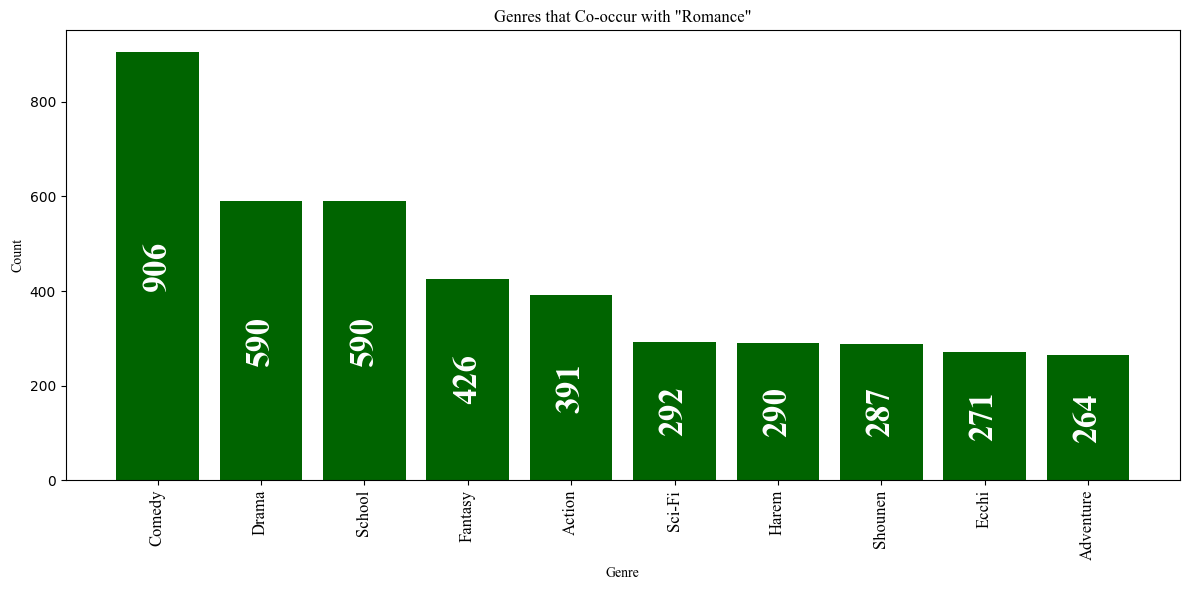

In [25]:
co_genres = []
for genres in df_filtered['genre']:
    co_genres.extend([g for g in genres if g != Genre])

genre_counts = Counter(co_genres)

genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])
genre_df = genre_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(genre_df['Genre'][:10], genre_df['Count'][:10], color='darkgreen')
plt.title(f'Genres that Co-occur with "{Genre}"', fontfamily='Times New Roman')
plt.xlabel('Genre', fontfamily='Times New Roman')
plt.ylabel('Count', fontfamily='Times New Roman')
plt.xticks(rotation=90, fontfamily='Times New Roman', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval * 0.5,
        f'{int(yval):,}'.replace(',', '.'),
        ha='center',
        va='center',
        color='white',
        fontsize=24,
        fontfamily='Times New Roman', 
        fontweight='bold',
        rotation=90
    )
        
plt.tight_layout()
plt.show()

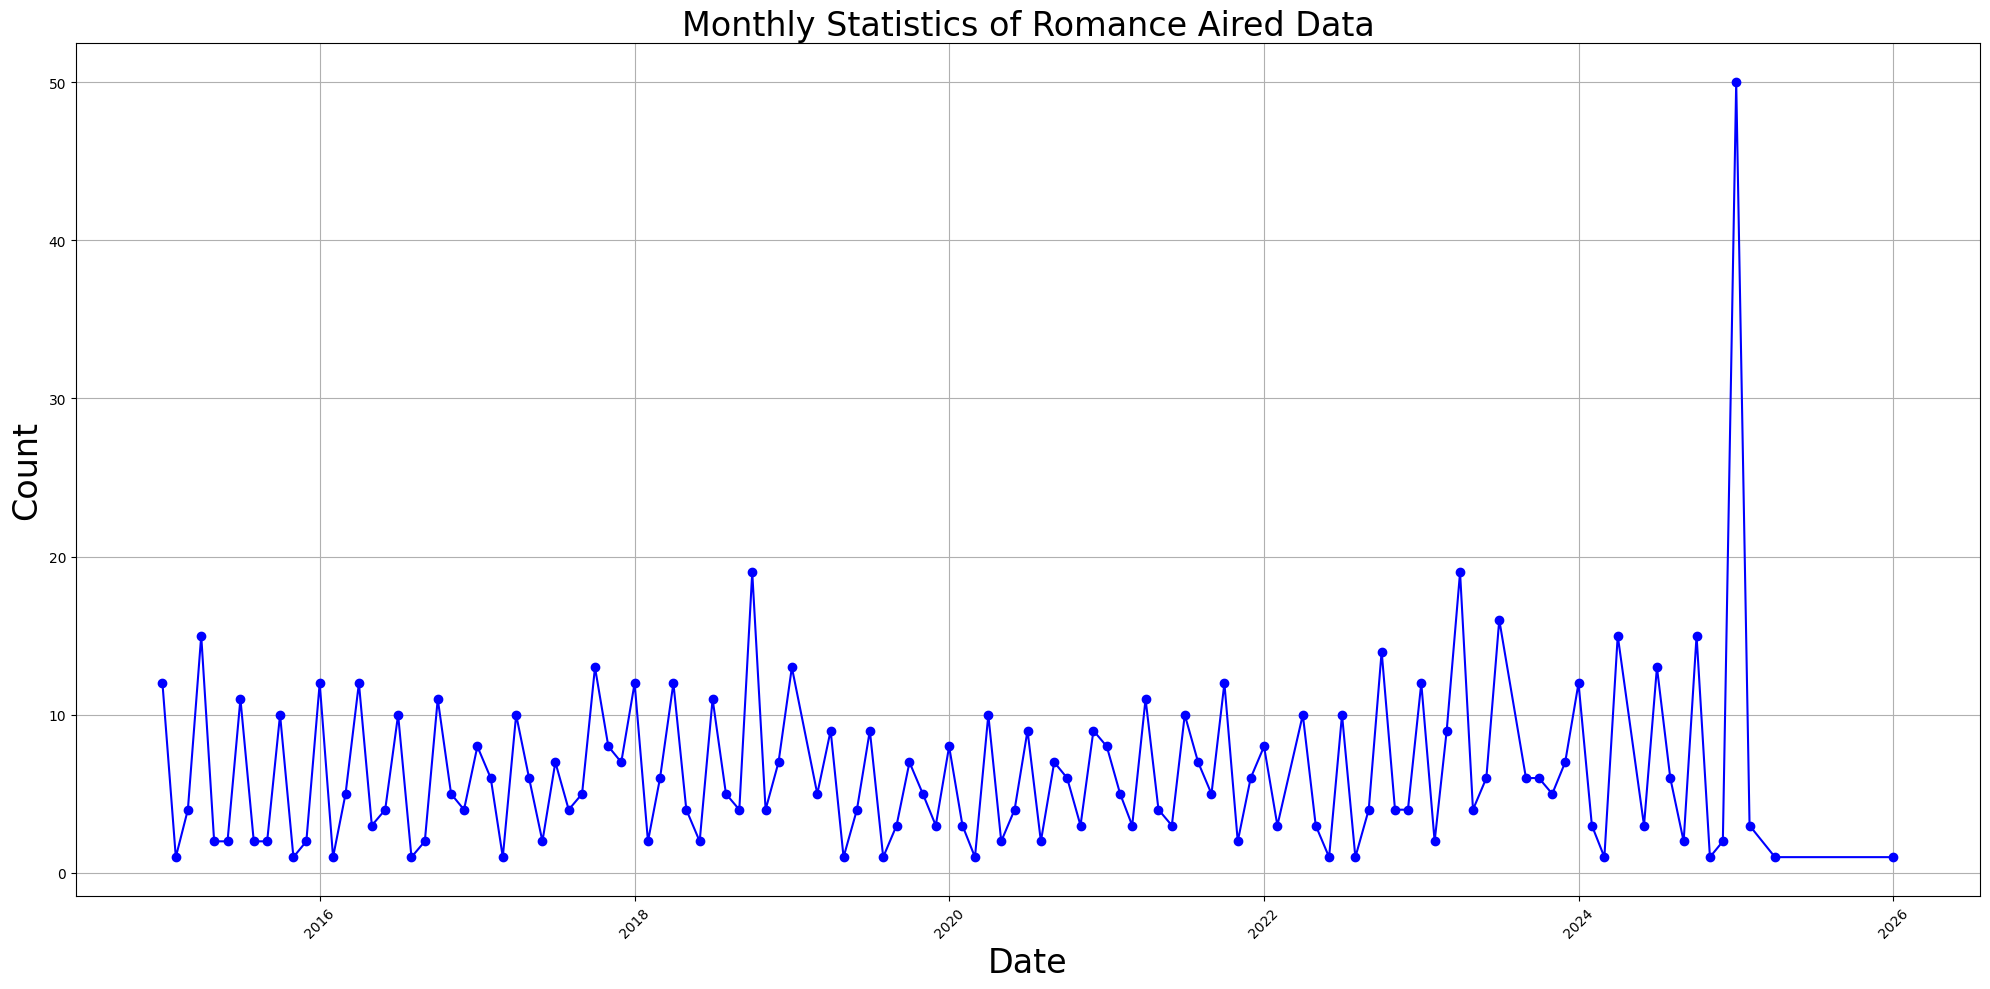

In [26]:
monthly_stats = genre_analysis(Genre, df, 10)

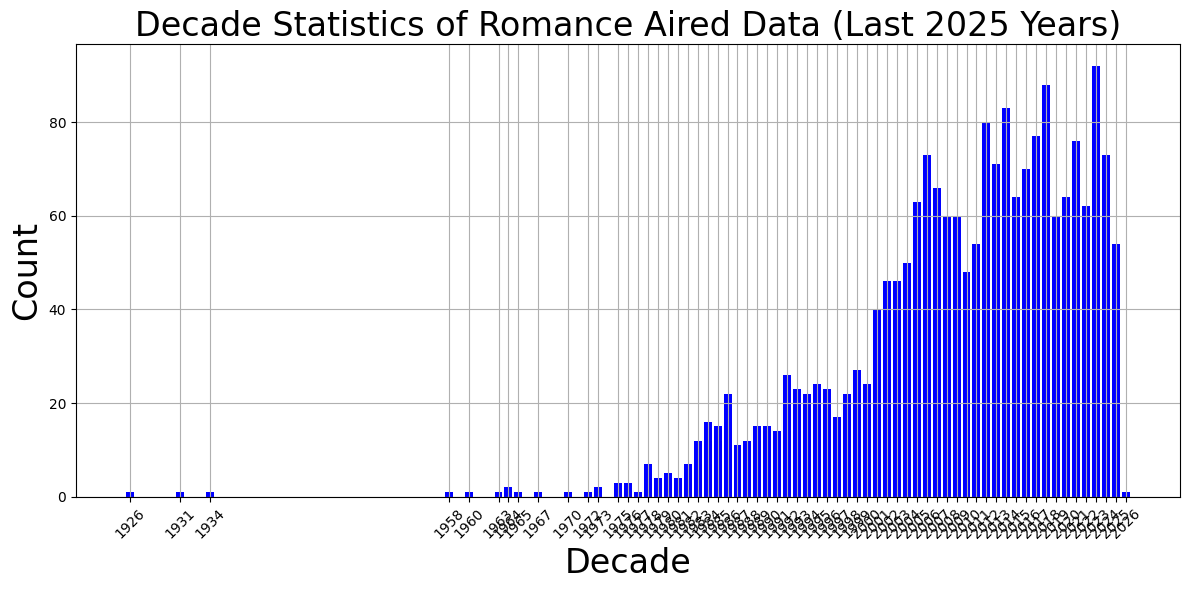

In [27]:
decade_stats = genre_analysis_decade(Genre, df, 1)
# print(decade_stats.to_markdown())

# Forecast Trend Genre

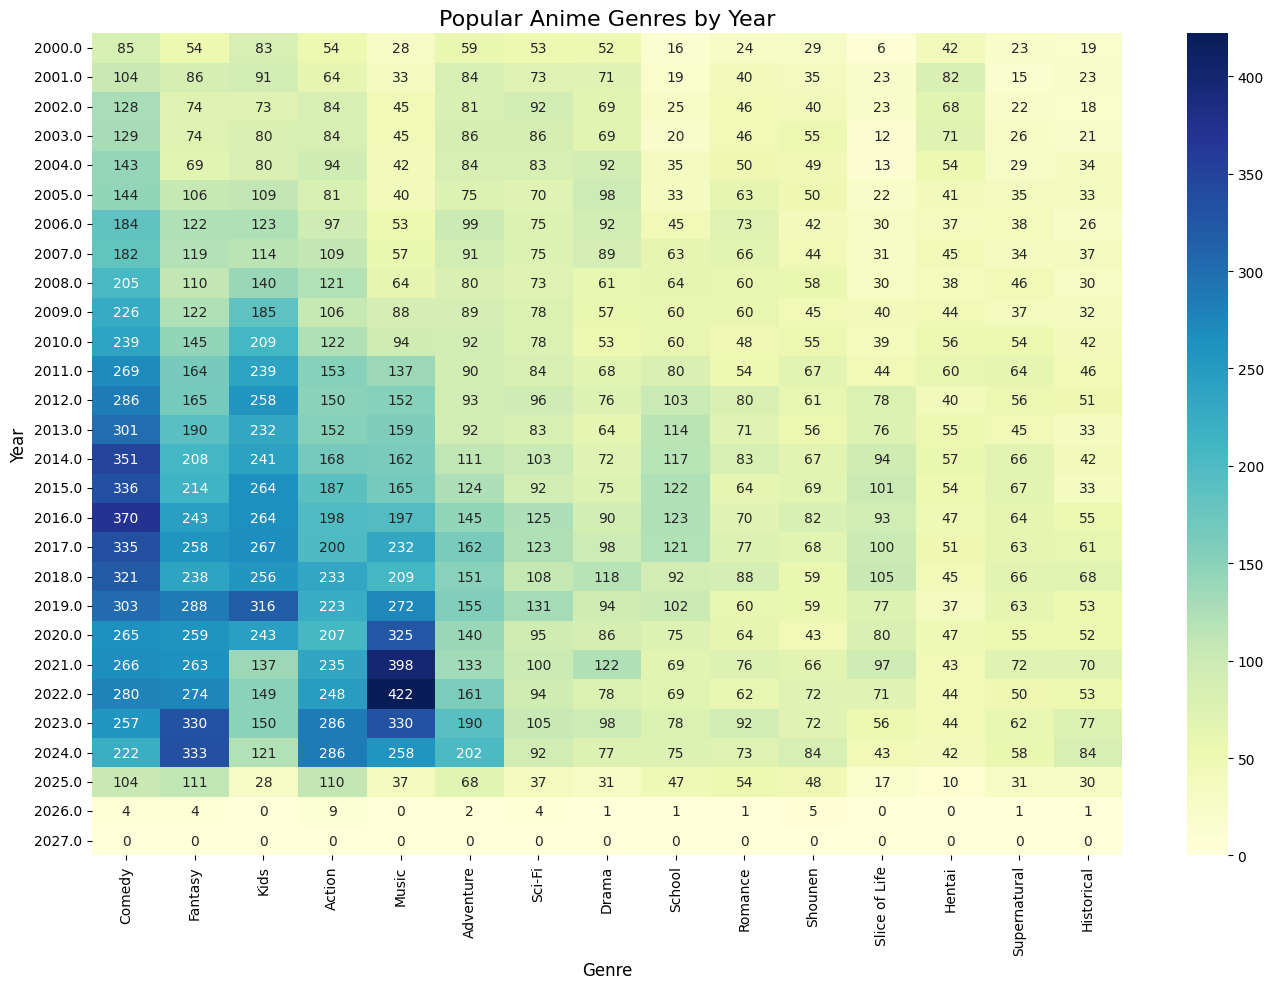

In [28]:
heatmap_data = plot_genre_heatmap(df) # top_n_genres=(len(df_genre_stats['genre'].unique())) , genres=["Slice of Life", "Action", "Isekai"]

In [29]:
# Run the analysis
trend_analysis = analyze_genre_trends(heatmap_data)
trend_analysis.head(15)

,recent_avg,growth_rate,prediction,trend_reliability,normalized_score
Fantasy,291.8,21.5,356.3,0.859392,0.905136
Action,252.4,20.9,315.1,0.941157,0.825767
Adventure,165.2,18.1,219.5,0.895403,0.622722
Shounen,67.4,8.8,93.8,0.846154,0.280397
Comedy,258.0,-9.5,229.5,0.476505,0.269880
Historical,67.2,7.1,88.5,0.615657,0.248423
Music,346.6,-20.2,286.0,0.241170,0.224186
Romance,73.4,3.4,83.6,0.202381,0.190319
Sci-Fi,97.2,-0.1,96.9,0.000903,0.166403
School,73.2,0.9,75.9,0.125000,0.143461


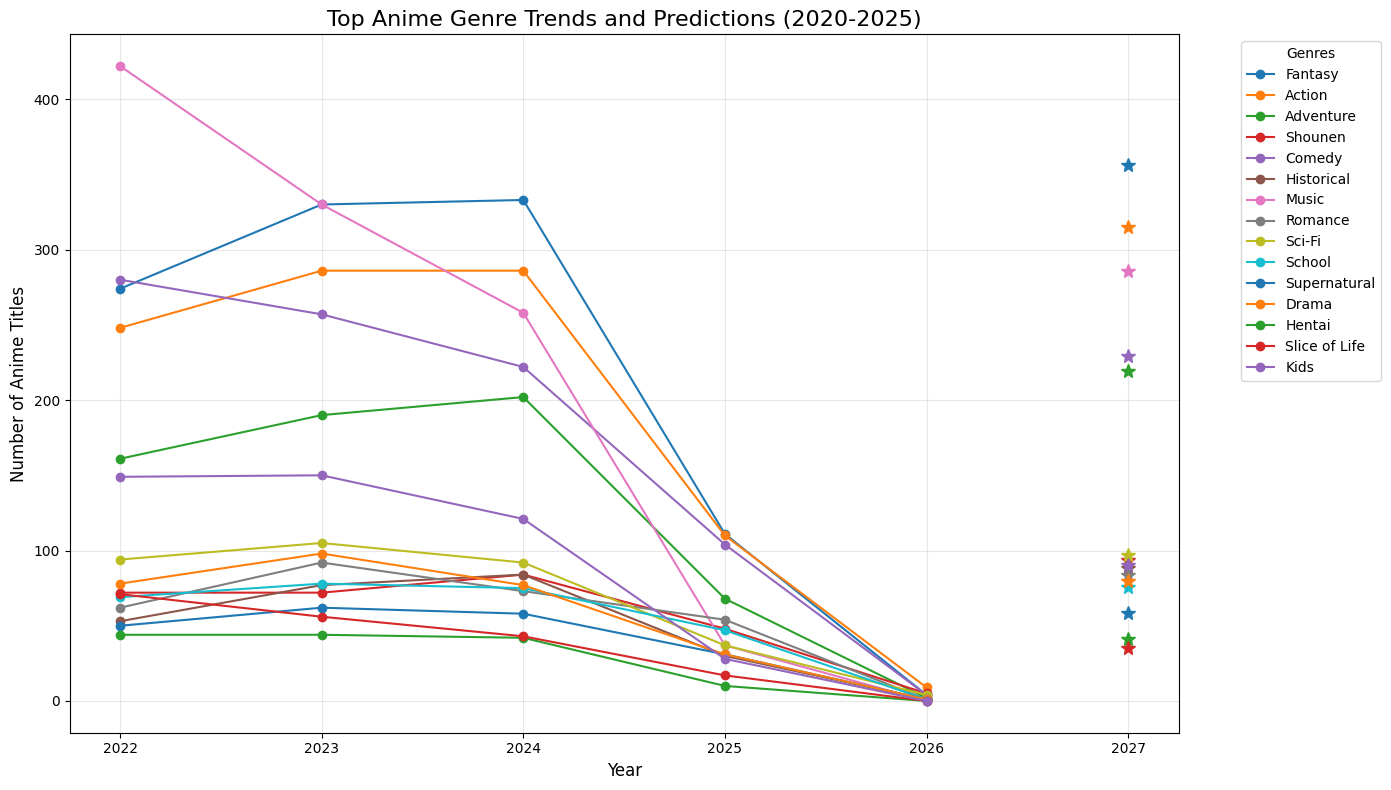

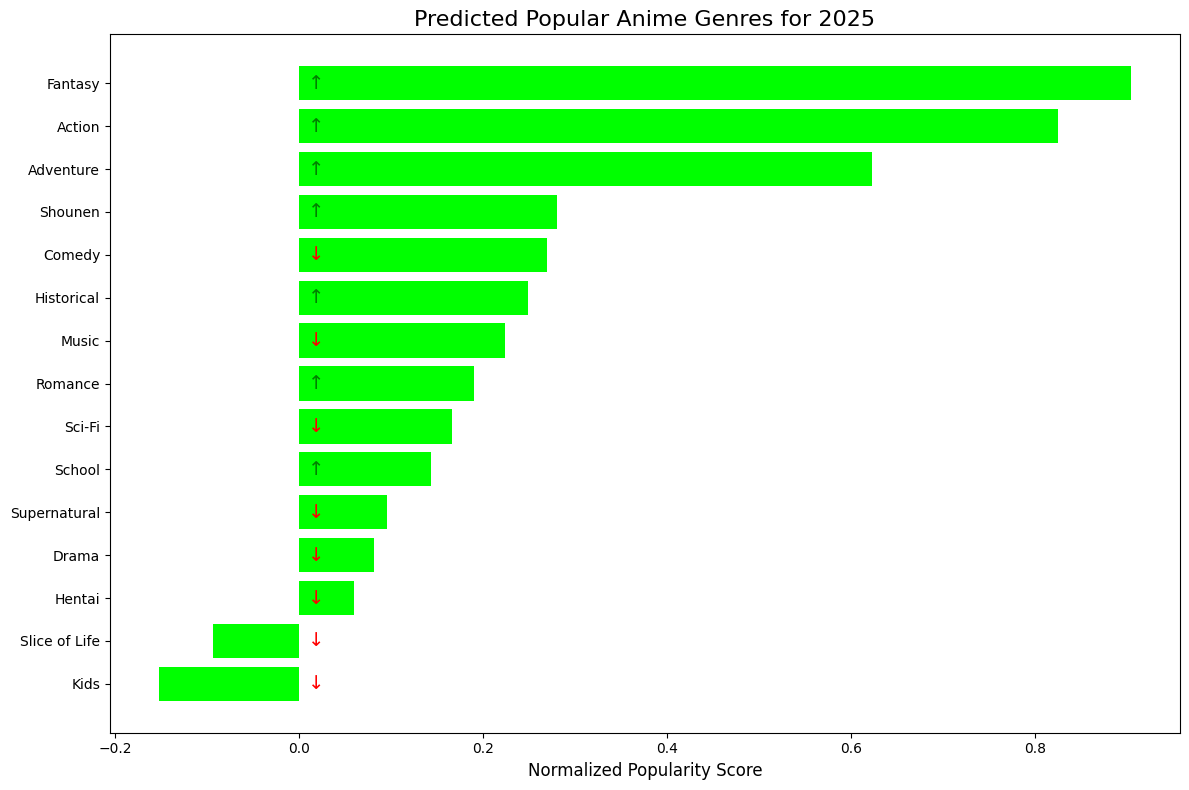

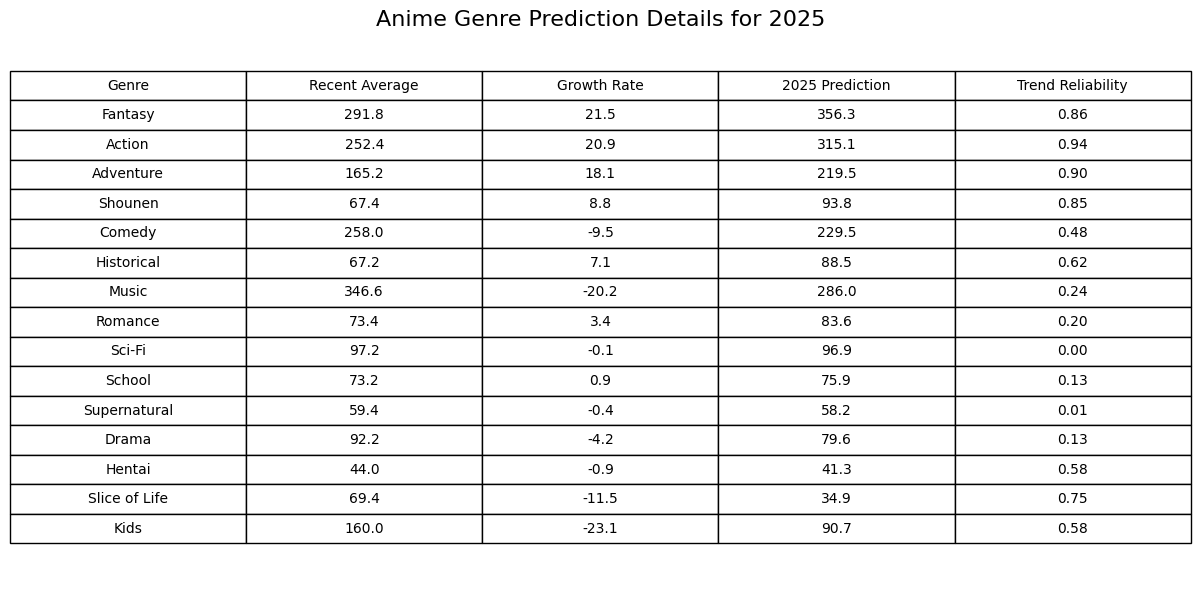

In [30]:
# Visualize the results
visualize_genre_trends(heatmap_data, trend_analysis, top_n=15)

In [31]:
(len(df_genre_stats['genre'].unique()))

78

In [32]:
# Generate and print the analysis
trend_report = generate_trend_analysis(trend_analysis)
print(trend_report)

# Anime Genre Trend Analysis for 2025

## Overall Trend Summary
Based on data from the past 5 years, the following genres are projected to be most popular in 2025:

1. **Fantasy**: Currently averaging 291.8 titles per year, with a increasing trend (7.4% per year). Projected to have 356.3 titles in 2025.
2. **Action**: Currently averaging 252.4 titles per year, with a increasing trend (8.3% per year). Projected to have 315.1 titles in 2025.
3. **Adventure**: Currently averaging 165.2 titles per year, with a increasing trend (11.0% per year). Projected to have 219.5 titles in 2025.
4. **Shounen**: Currently averaging 67.4 titles per year, with a increasing trend (13.1% per year). Projected to have 93.8 titles in 2025.
5. **Comedy**: Currently averaging 258.0 titles per year, with a decreasing trend (3.7% per year). Projected to have 229.5 titles in 2025.
6. **Historical**: Currently averaging 67.2 titles per year, with a increasing trend (10.6% per year). Projected to have 88.5 titles in